<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = 'MohammadParsa Dini'
std_id = '400101204'

In [3]:
import torch 

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('HAHA! MY BELOVED GPU IS AVAILABLE')
else:
    device = torch.device('cpu')
    print(' HEEB WORKING ON CPU FOR CRYING OUT LOUD')

HAHA! MY BELOVED GPU IS AVAILABLE


In [4]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [5]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [6]:
# TODO: Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [7]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [9]:
print(len(merged_loader))
print(len(merged_dataset))

1094
70000


In [13]:
from collections import defaultdict

def plot_class_distribution(mergeloader):
    classes = [0,1,2,3,4,5,6,7,8,9]
    # TODO: Initialize a dictionary to count occurrences of each class
    occurr = defaultdict(int)
    # TODO: Iterate through the DataLoader to count the labels
    for batch_idx, (data, target) in enumerate(mergeloader):
        for label in target:
            occurr[int(label)] += 1
    # TODO: Plot the histogram    
    plt.figure(figsize=(12,4))
    my_occurr = []
    
    for i in range(10):
        my_occurr.append(occurr[i])
    
    plt.bar(classes, my_occurr)
    plt.xlabel('Classes')
    plt.ylabel('Occurrences - Frequency')
    plt.title('Class Distribution in Merged Dataset')
    plt.grid(True)
    plt.show()
    #return my_occurr, classes

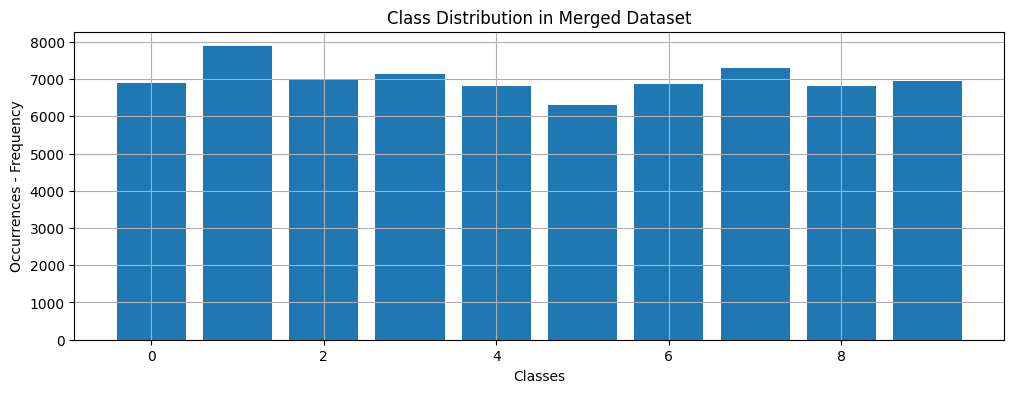

In [14]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [12]:
from collections import defaultdict

def plot_class_averages(dataloader):
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    sums = defaultdict(lambda: torch.zeros(28, 28))
    counts = defaultdict(int)
    
    # Iterate over the DataLoader to accumulate sums and counts
    for batch_idx, (data, target) in enumerate(dataloader):
        for img, label in zip(data, target):
            sums[int(label)] += img.squeeze(0)
            counts[int(label)] += 1
    
    # Calculate the average images for each class
    averages = {label: sums[label] / counts[label] for label in range(10)}
    
    # Plot the averages
    plt.figure(figsize=(12, 4))
    for i in classes:
        plt.subplot(2, 5, i + 1)  
        plt.imshow(averages[i].numpy(), cmap='gray')  
        plt.title(f'Class {i}')
        plt.axis('off')
    
    plt.show()

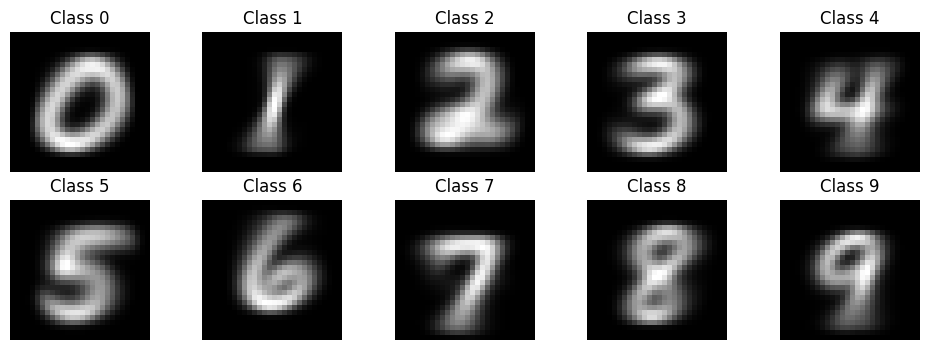

In [20]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    input_dim = 784
    hidden_dim = 400
    def __init__(self, latent_dim=2):
        # TODO
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, latent_dim)
        self.fc3 = nn.Linear(self.hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, self.hidden_dim)
        self.fc5 = nn.Linear(self.hidden_dim, self.input_dim)

    def encode(self, x):
        # TODO
        h = F.relu(self.fc1(x))              # from input to hidden layer
        return self.fc2(h), self.fc3(h)      # from the hidden layer to (mu, logvar)

    def reparameterization(self, mean, logvar):
        # TODO
        epsilon = torch.randn(1)                         # epsilon ~ N(0,1)
        return mean + epsilon * torch.exp(logvar / 2)    # mu + exp(logvar/2) * epsilon ~ N(mu, exp(logvar)=var) 

    def decode(self, x):
        # TODO
        h = F.relu(self.fc4(x))              # from latent space to  hidden layer
        return F.relu(self.fc5(h))           # and from hidden layer to the image space 

    def forward(self, x):
        # TODO
        mu , logvar = self.encode(x)
        z = self.reparameterization(mu, logvar)
        x_recontructed = self.decode(z)
        

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    # TODO
    pass

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [ ]:
def plot_losses(losses):
    # TODO
    pass


def train(model, optimizer, n_epochs=50, losses=losses):
    # TODO
    pass

Loss = 142.34: 100%|██████████| 50/50 [13:06<00:00, 15.72s/it]


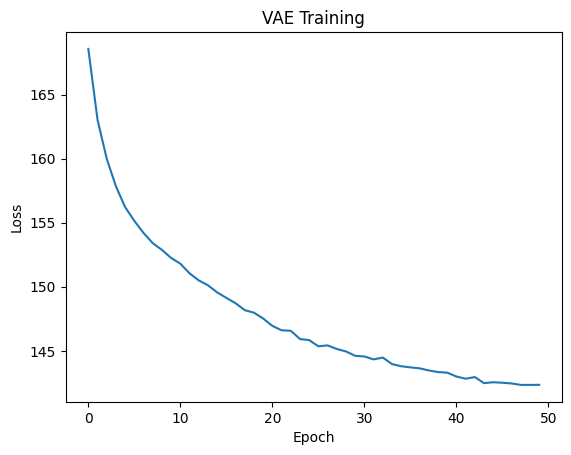

In [ ]:
losses += train(model, optimizer)

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [ ]:
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    pass

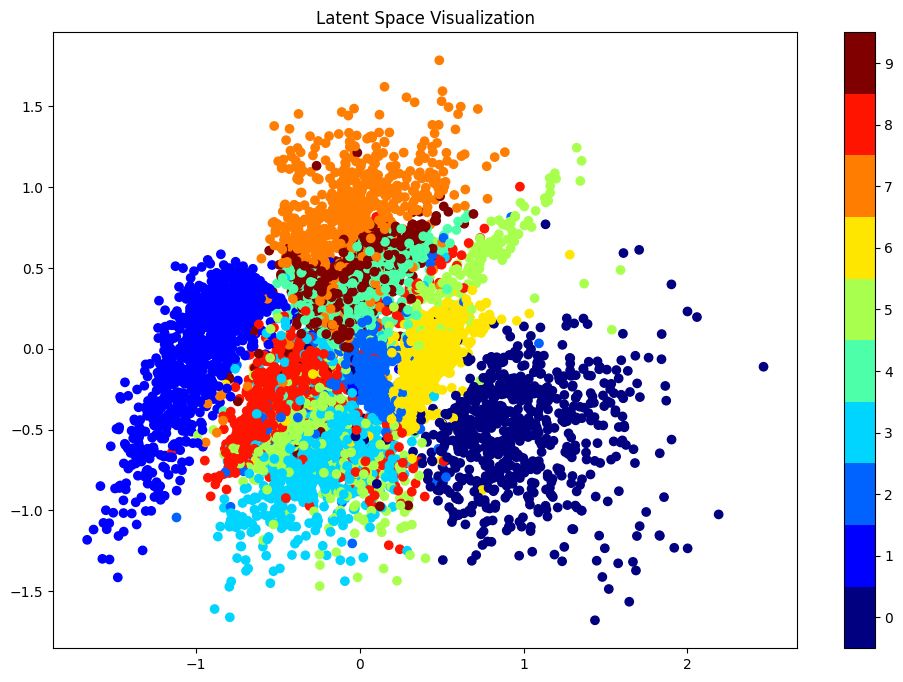

In [ ]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [ ]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    pass

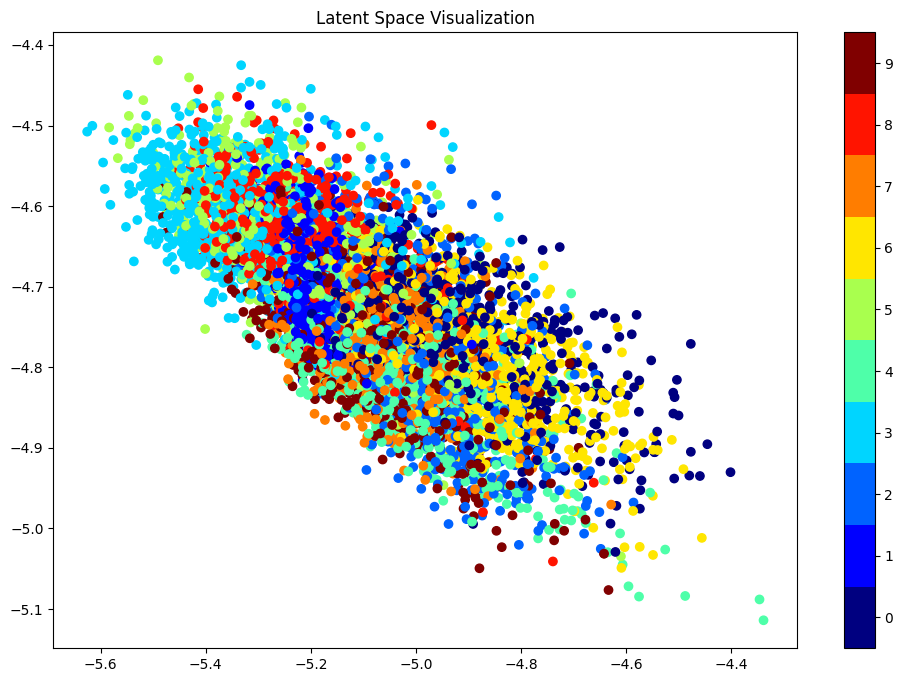

In [ ]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [ ]:
def generate_digit(mean, var):
    # TODO: Return the generated image
    pass

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [ ]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid

    # TODO: Generate images for the grid

    # TODO: Display the results
    pass

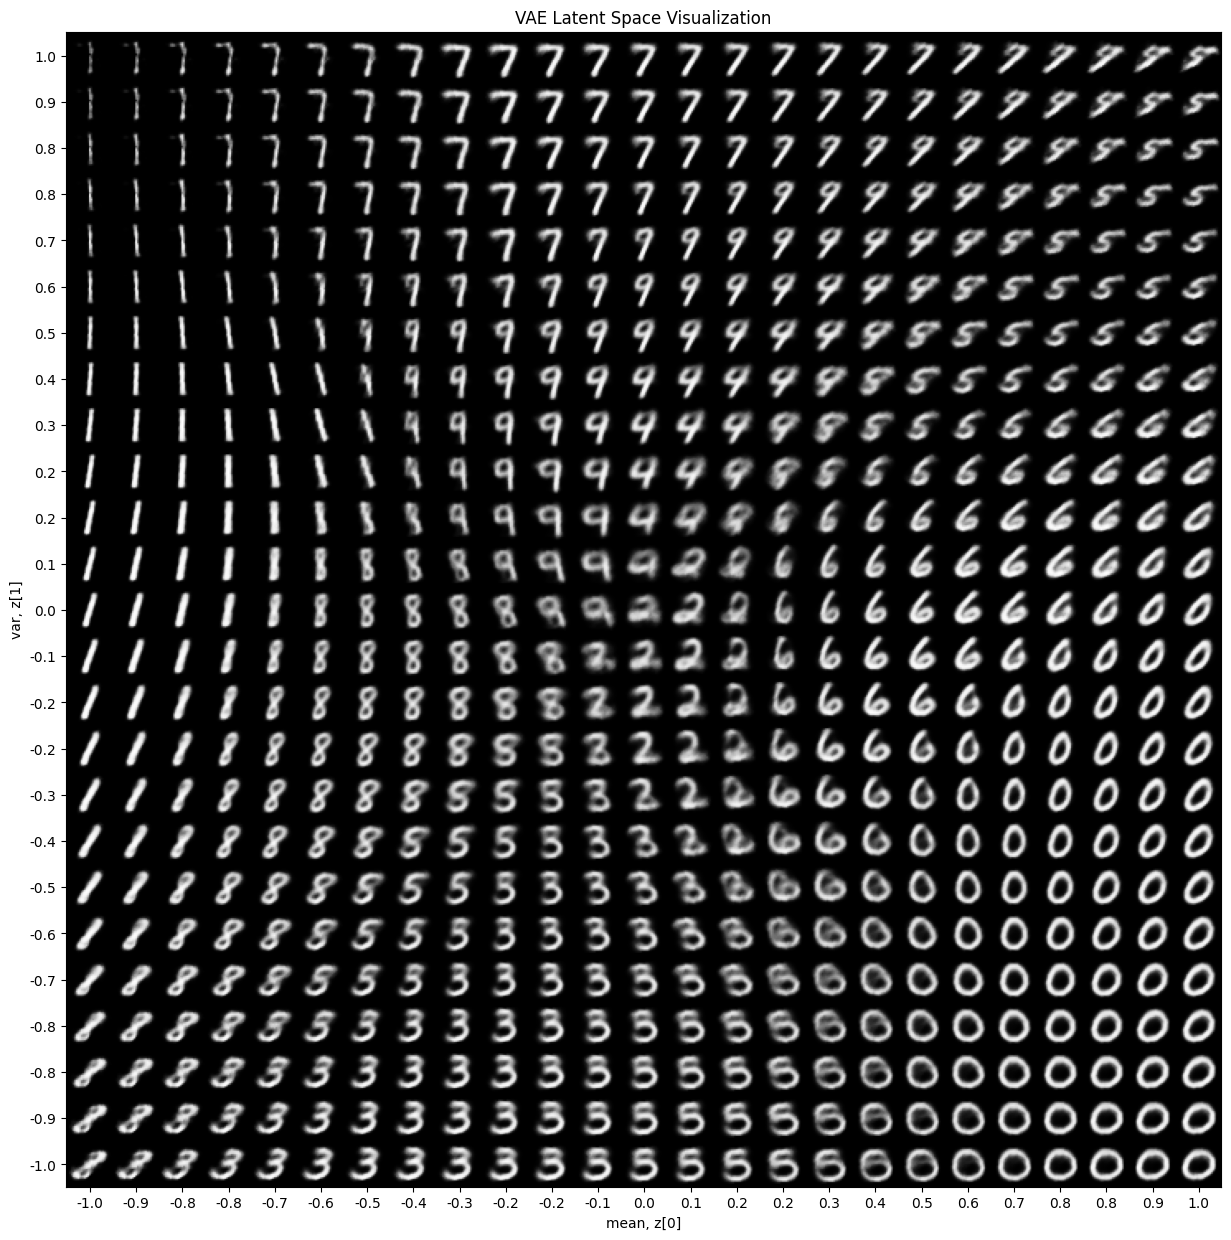

In [ ]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*